# "Challenge #2"
    MADS-ML
    Jannik Paul

## Experimental ML to train prediction on visitor numbers to the beach of Scharbeutz

> Please note: **Performance Warning**. The Notebook contains heavy computation required with both the SVM and RFC Regressors. The NB comes 'as is', saved after running at night on a underclocked desktop with 24 threads. Please adjust values at your own discretion before re-running, they can be found by searching for: n_jobs , 3409 (for the runs and building indices to save results).

### Introduction
Scharbeutz/Sierksdorf are communities situated at the eastern coast of Schleswig-Holstein, in the Northern Bay Area of Luebeck and commonly host one of the most popular beaches near Hamburg. During the last years, the community of Scharbeutz saw a rapid increase in influx of inner-German tourists from Hamburg and also nearby locals.  

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f6/Scharbeutz_Promenade.JPG/2560px-Scharbeutz_Promenade.JPG" alt="drawing" width="300"/>  

"Scharbeutz Beach", *CC BY-SA 3.0, Wikipedia*

### Sensor Data aggregating number of visitors
This has led the community of Scharbeutz to set up triggers to count the number of people entering or to substract when leaving the area. Furthermore the community is interested in being able to predict how many people are coming to its space at a given time with the help of AI.  

Information on a possible number of tourists will help the local vendors and restaurants to judge what is to come, prepare food supplies and plan staff for the day, help community administration to plan demand for and workload on police officers, life guards at the beaches, ambulance readiness, flights to pull advertisement banners by plane, and more.  

### Features
To build a Machine Learning experiment, we need good features. Initially, days of the week, bridge days, public holidays were also used, however these led to worse predictions. It was found that the models at hand worked best on the weather features alone, date and hour of the day as a representation to where we are during the day. The categories date, hour of the day, wind, rain, temperature, and precipitation are hence used.

### Labels
The label is the aggregated number of people per day. It is created by the counters triggering the movement of people. If a person enters the area, it adds one. If a person leaves, it substracts one. At midnight, the counter resets. The area encompass the community and public entries to the beach. During the latter parts of the days, negative numbers start accumulating. It posed the question on wether to mask negative numbers by zero, however that reduced the quality of the results of the models. The negative numbers can be explained (I have lived in Haffkrug for two years) by being caused by locals - after the day of work or school, they may stroll to the beach from within the area or use non-public entries or walk their dog, while leaving through the public entries because these offer benches to sit and clean feet and shoes from sand.  

> Note: Part of the data (Scharbeutz Strand Sensor Data) in this machine learning experiment may also get used in-part in my recently reassigned application project (the initial company would not provide the necessary data and configurations to work on the project so it was cancelled at the end of the semester) which is aiming at building a predictor. As the Sensor Data was a team effort, it is not covered in this NB and shared as ready-files in folder "Schleswig Holstein", while all else is not a team effort and thus covered in this Notebook.

In [2]:
# Basics
from collections import Counter
import datetime
from functools import reduce
import json
import math
import numpy as np
from numpy import asarray
import os
import pandas as pd
from pandas import DataFrame
from pandas import concat
import time

# Graphics
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# Public API to request data
import requests
from wetterdienst import Settings
from wetterdienst.util.cli import setup_logging
from wetterdienst.provider.dwd.mosmix import (
    DwdForecastDate,
    DwdMosmixRequest,
    DwdMosmixType,
)
from wetterdienst.provider.dwd.observation import (
    DwdObservationRequest,
    DwdObservationPeriod, 
    DwdObservationResolution, 
    DwdObservationParameter, 
    DwdObservationDataset
)

# FutureWarnings
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

# Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

# Data Acquisition  
### Historical Data  
We get the names of the five weather stations, which are the closest to Scharbeutz' long beach in Luebeck's Bay Area. With this information, we can check out the weather station's location on google maps.  
Luebeck and Luebeck Blankensee are too far inland, and Boltenhagen is too far east with a possibly different micro-climate. Pelzerhaken however sits right at the top of Luebeck's Bay Area.

.filter_by_rank() is a practical wrapper to get nearby stations from wetterdienst.

In [3]:
DwdObservationRequest(
    parameter=[
       "temperature_air_mean_200"
    ],
    resolution=DwdObservationResolution.HOURLY,
    start_date="2020-01-01",
    end_date="2022-03-23"
).filter_by_rank(
    54.0224961,   # latitude
    10.7544158,   # longitude
    5             # number of listed nearby stations   
).df

,station_id,from_date,to_date,height,latitude,longitude,name,state,distance
0,03897,2002-01-01 00:00:00+00:00,2022-06-27 00:00:00+00:00,2.0,54.0893,10.8773,Pelzerhaken,Schleswig-Holstein,10.932137
1,03085,1951-01-01 00:00:00+00:00,1985-03-01 00:00:00+00:00,15.0,53.8773,10.6915,Lübeck,Schleswig-Holstein,16.661731
2,03086,1985-03-01 00:00:00+00:00,2022-06-27 00:00:00+00:00,15.0,53.8025,10.6989,Lübeck-Blankensee,Schleswig-Holstein,24.731202
3,00596,1973-01-01 00:00:00+00:00,2022-06-27 00:00:00+00:00,15.0,54.0027,11.1908,Boltenhagen,Mecklenburg-Vorpommern,28.597685
4,06163,2001-04-01 00:00:00+00:00,2022-06-27 00:00:00+00:00,27.0,54.1654,10.3519,Dörnick,Schleswig-Holstein,30.683521


With the name of the station now found, we request the weather features from the Deutscher Wetterdienst API.

In [4]:
name_station = "Pelzerhaken"

request_temp = DwdObservationRequest(
    parameter=[
       "temperature_air_mean_200"
    ],
    resolution=DwdObservationResolution.HOURLY,
    start_date="2020-01-01",
    end_date="2022-03-23"
).filter_by_name(name=name_station)


request_wind = DwdObservationRequest(
    parameter=[
       "wind_speed"
    ],
    resolution=DwdObservationResolution.HOURLY,
    start_date="2020-01-01",
    end_date="2022-03-23"
).filter_by_name(name=name_station)


request_rain = DwdObservationRequest(
    parameter=[
       "precipitation_height"
    ],
    resolution=DwdObservationResolution.HOURLY,
    start_date="2020-01-01",
    end_date="2022-03-23"
).filter_by_name(name=name_station)

request_form = DwdObservationRequest(
    parameter=[
       "precipitation_form"
    ],
    resolution=DwdObservationResolution.HOURLY,
    start_date="2020-01-01",
    end_date="2022-03-23"
).filter_by_name(name=name_station)

request_snow = DwdObservationRequest(
    parameter=[
       "snow_depth"
    ],
    resolution=DwdObservationResolution.DAILY,
    start_date="2020-01-01",
    end_date="2022-03-23"
).filter_by_name(name=name_station)


station_temp = request_temp.values.all().df
station_wind = request_wind.values.all().df
station_rain = request_rain.values.all().df
station_snow = request_snow.values.all().df
station_form = request_form.values.all().df

As we are exploring, we take a look at what we have gotten to get a quick overview of what we will be working with.

In [5]:
station_temp.head(2)

,station_id,dataset,parameter,date,value,quality
0,03897,temperature_air,temperature_air_mean_200,2020-01-01 00:00:00+00:00,275.45,3.0
1,03897,temperature_air,temperature_air_mean_200,2020-01-01 01:00:00+00:00,274.15,3.0


In [6]:
station_wind.head(2)

,station_id,dataset,parameter,date,value,quality
0,03897,wind,wind_speed,2020-01-01 00:00:00+00:00,2.5,10.0
1,03897,wind,wind_speed,2020-01-01 01:00:00+00:00,1.8,10.0


In [7]:
station_rain.head(2)

,station_id,dataset,parameter,date,value,quality
0,03897,precipitation,precipitation_height,2020-01-01 00:00:00+00:00,0.0,3.0
1,03897,precipitation,precipitation_height,2020-01-01 01:00:00+00:00,0.0,3.0


In [8]:
station_snow.head(2)

,station_id,dataset,parameter,date,value,quality
0,03897,climate_summary,snow_depth,2020-01-01 00:00:00+00:00,0.0,3.0
1,03897,climate_summary,snow_depth,2020-01-02 00:00:00+00:00,0.0,3.0


In [9]:
station_form.head(2)

,station_id,dataset,parameter,date,value,quality
0,03897,precipitation,precipitation_form,2020-01-01 00:00:00+00:00,NaN,NaN
1,03897,precipitation,precipitation_form,2020-01-01 01:00:00+00:00,0.0,3.0


# Feature engineering  
After the initial requests we can already start engineering the featureset. The labels will get treated similarly later and eventually everything will get merged into one big dataframe.  

At first we separate the date values, we want to use them as indices to match and merge dataframes on them later.

In [10]:
# only get the date values
weather_features = station_rain.copy()
weather_features.drop(columns=['value', 'quality', 'parameter', 'dataset', 'station_id'], inplace=True) 
weather_features

,date
0,2020-01-01 00:00:00+00:00
1,2020-01-01 01:00:00+00:00
2,2020-01-01 02:00:00+00:00
3,2020-01-01 03:00:00+00:00
4,2020-01-01 04:00:00+00:00
...,...
19484,2022-03-22 20:00:00+00:00
19485,2022-03-22 21:00:00+00:00
19486,2022-03-22 22:00:00+00:00
19487,2022-03-22 23:00:00+00:00


To get the values of the weather on an hourly basis.

In [11]:
weather_features["wind_speed"] = station_wind["value"]
weather_features["temperature"] =station_temp["value"]
weather_features["rain"] = station_rain["value"]
weather_features["form"] = station_form["value"]

weather_features = weather_features.astype({"wind_speed": "float", "temperature": "float", "rain": "float", "form":"float"})

In [12]:
weather_features.head(20)

,date,wind_speed,temperature,rain,form
0,2020-01-01 00:00:00+00:00,2.5,275.45,0.0,NaN
1,2020-01-01 01:00:00+00:00,1.8,274.15,0.0,0.0
2,2020-01-01 02:00:00+00:00,1.9,274.55,0.0,0.0
3,2020-01-01 03:00:00+00:00,2.3,275.35,0.0,NaN
4,2020-01-01 04:00:00+00:00,2.0,275.45,0.0,0.0
5,2020-01-01 05:00:00+00:00,1.8,276.35,0.0,0.0
6,2020-01-01 06:00:00+00:00,2.1,276.65,0.0,NaN
7,2020-01-01 07:00:00+00:00,2.5,277.15,0.0,0.0
8,2020-01-01 08:00:00+00:00,2.6,277.25,0.0,0.0
9,2020-01-01 09:00:00+00:00,2.7,277.25,0.0,NaN


### Aggregation of data
At first we are resampling to 6 hours, which may be good for plots (as the resolution of data is smaller) and ease computation. But we will also run along with the hourly basis, as this gave better computational results.

In [13]:
# prepare 6 hours df
weather_features_6 = weather_features.copy()
weather_features_6.drop(columns=["form"], inplace=True)
weather_features_6.set_index("date", inplace=True)

# resample the data to 6 hours
weather_features_6 = weather_features_6.resample("6H").mean()
weather_features_6.reset_index(inplace=True)
weather_features_6["precipitation_form"]=5

In [15]:
weather_features_6.head(3)

,date,wind_speed,temperature,rain,precipitation_form
0,2020-01-01 00:00:00+00:00,2.050000,275.216667,0.0,5
1,2020-01-01 06:00:00+00:00,2.866667,277.150000,0.0,5
2,2020-01-01 12:00:00+00:00,4.533333,276.683333,0.0,5


In [16]:
weather_features["date"] = pd.to_datetime(weather_features["date"])
weather_features["Year"]= weather_features["date"].dt.year
weather_features["Month"]= weather_features["date"].dt.month
weather_features["Day"]= weather_features["date"].dt.day
weather_features["DayOfWeek"]= weather_features["date"].dt.dayofweek
weather_features["Hour"]= weather_features["date"].dt.hour

weather_features_6["date"] = pd.to_datetime(weather_features_6["date"])
weather_features_6["Year"]= weather_features_6["date"].dt.year
weather_features_6["Month"]= weather_features_6["date"].dt.month
weather_features_6["Day"]= weather_features_6["date"].dt.day
weather_features_6["DayOfWeek"]= weather_features_6["date"].dt.dayofweek
weather_features_6["Hour"]= weather_features_6["date"].dt.hour

In [17]:
weather_features_6.head(2)

,date,wind_speed,temperature,rain,precipitation_form,Year,Month,Day,DayOfWeek,Hour
0,2020-01-01 00:00:00+00:00,2.050000,275.216667,0.0,5,2020,1,1,2,0
1,2020-01-01 06:00:00+00:00,2.866667,277.150000,0.0,5,2020,1,1,2,6


In [19]:
weather_features.head(3)

,date,wind_speed,temperature,rain,form,Year,Month,Day,DayOfWeek,Hour
0,2020-01-01 00:00:00+00:00,2.5,275.45,0.0,NaN,2020,1,1,2,0
1,2020-01-01 01:00:00+00:00,1.8,274.15,0.0,0.0,2020,1,1,2,1
2,2020-01-01 02:00:00+00:00,1.9,274.55,0.0,0.0,2020,1,1,2,2


Let's take a look if there is data missing. We suspected form (precipitation_form) in the hourly set, but there's also something regarding rain. It seems the sensors sometimes fell out of order for a while, which is to be expected in a real, non-synthetic dataset. We'll always have to look for such occurances one way or another.

<AxesSubplot:>

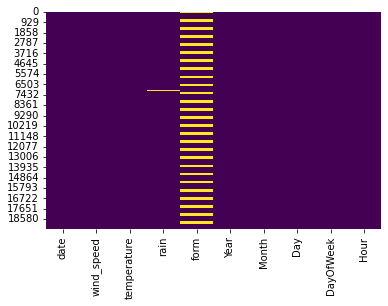

In [20]:
sns.heatmap(weather_features.isnull(), cbar=False, cmap='viridis')

The 6H set does't have this issue due to the aggregation.

<AxesSubplot:>

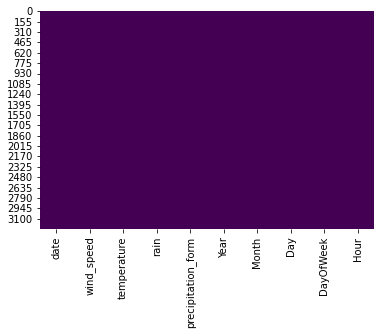

In [24]:
sns.heatmap(weather_features_6.isnull(), cbar=False, cmap='viridis')

We should just fill up those missing numbers with zeros. We can't gain new information when it is lost. In the overall picture it won't affect our set too much. We'll later see wether to run on 1H or 6H.  

While we won't have a dashboard / full production environment in ML, our ML experiments should work with both.

<AxesSubplot:>

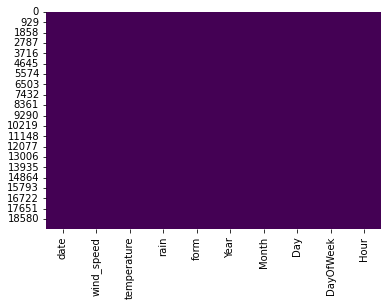

In [21]:
weather_features.fillna(0, inplace=True)
sns.heatmap(weather_features.isnull(), cbar=False, cmap='viridis')

<AxesSubplot:>

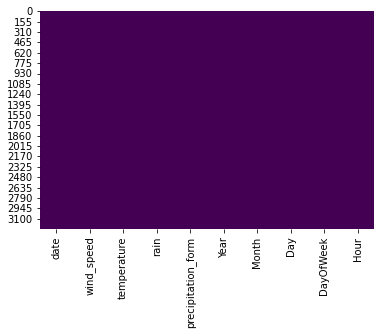

In [22]:
weather_features_6.fillna(0, inplace=True)
sns.heatmap(weather_features_6.isnull(), cbar=False, cmap='viridis')

Looks clean now. Could also go with code, but some graphics in the mix keep it interesting.

### Categorization  
Now the features get categorized in order to prepare them for one-hot-encoding. If we only used a Random Forest Classifier, we would *not* use one-hot-encoding, as the Random Forest reacts sensitive to OHE and then tends towards sparse decision trees.  

Here is why we still do it: We are also using kNN and SVM (and all three models as Regressors).  

We want to compare the 3 models on the same dataset ceteris paribus, so the Random Forest Regressor will have to deal with that handicap. "*Sorry, Random Forest!*"

In [25]:
# wind
weather_features["wind_category"] = weather_features["wind_speed"]
j = 0
for i in weather_features["wind_category"]:
    if i < 0.3:
        weather_features.loc[j, "wind_category"]= 0
    if  0.3 <= i < 1.6:
        weather_features.loc[j, "wind_category"]= 1
    if  1.6 <= i < 3.4:
        weather_features.loc[j, "wind_category"]= 2
    if  3.4 <= i < 5.5:
        weather_features.loc[j, "wind_category"]= 3
    if  5.5 <= i < 8:
        weather_features.loc[j, "wind_category"]= 4
    if  8 <= i < 10.8:
        weather_features.loc[j, "wind_category"]= 5
    if  10.8 <= i < 13.9:
        weather_features.loc[j, "wind_category"]= 6
    if  13.9 <= i < 17.2:
        weather_features.loc[j, "wind_category"]= 7
    if  17.2 <= i < 20.7:
        weather_features.loc[j, "wind_category"]= 8
    if  20.7 <= i < 24.4:
        weather_features.loc[j, "wind_category"]= 9
    if  24.4 <= i < 28.4:
        weather_features.loc[j, "wind_category"]= 10
    if  28.4 <= i < 32.6:
        weather_features.loc[j, "wind_category"]= 11
    if  i > 32.7:
        weather_features.loc[j, "wind_category"]= 12
    j +=1
    
# rain
weather_features["rain_category"] = weather_features["rain"]
j = 0
for i in weather_features["rain"]:
    if i < 0.5:
        weather_features.loc[j, "rain_category"]=0.5
    if 0.5 <= i < 2.5:
        weather_features.loc[j, "rain_category"]=2.5
    if 2.5 <= i < 5:
        weather_features.loc[j, "rain_category"]=5
    if 5 <= i < 10:
        weather_features.loc[j, "rain_category"]=10
    if 10 <= i < 50:
        weather_features.loc[j, "rain_category"]=50
    if i > 50:
        weather_features.loc[j, "rain_category"]=51
    j += 1
    
# temperature
weather_features["temp_category"] = weather_features["temperature"]
j = 0
for i in weather_features["temperature"]:
    if i < 263.15:
        weather_features.loc[j, "temp_category"] = -10
    if 263.15 <= i < 273.15:
        weather_features.loc[j, "temp_category"] = 0   
    if 273.15 <= i < 283.15:
        weather_features.loc[j, "temp_category"] = 10   
    if 283.15 <= i < 291.15:
        weather_features.loc[j, "temp_category"] = 18
    if 291.15 <= i < 297.15:
        weather_features.loc[j, "temp_category"] = 24
    if 297.15 <= i < 303.15:
        weather_features.loc[j, "temp_category"] = 30
    if 303.15 <= i < 308.15:
        weather_features.loc[j, "temp_category"] = 35
    if i > 308.15:
        weather_features.loc[j, "temp_category"] = 35
    j+=1
    
# snow, snowwater, rain, as given by DWD
weather_features["precipitation_form"] = weather_features["form"]
j=0
for i in weather_features["form"]:
    if math.isnan(i):
        weather_features.loc[j, "precipitation_form"] = 0
    if i == 0:
        weather_features.loc[j, "precipitation_form"] = 0
    if i == 1:
        weather_features.loc[j, "precipitation_form"] = 1  
    if i == 4:
        weather_features.loc[j, "precipitation_form"] = 0
    if i == 6:
        weather_features.loc[j, "precipitation_form"] = 1 
    if i == 7:
        weather_features.loc[j, "precipitation_form"] = 2
    if i == 8:
        weather_features.loc[j, "precipitation_form"] = 2
    if i == 9:
        weather_features.loc[j, "precipitation_form"] = 0
    j+= 1
        

In [27]:
weather_features.tail(2)

,date,wind_speed,temperature,rain,form,Year,Month,Day,DayOfWeek,Hour,wind_category,rain_category,temp_category,precipitation_form
19487,2022-03-22 23:00:00+00:00,2.8,276.45,0.0,0.0,2022,3,22,1,23,2.0,0.5,10.0,0.0
19488,2022-03-23 00:00:00+00:00,2.8,278.25,0.0,0.0,2022,3,23,2,0,2.0,0.5,10.0,0.0


Here we also got the last column which is part of the next day, so we want to drop that.

In [28]:
weather_features = weather_features[:-1]

In [29]:
weather_features.tail(2)

,date,wind_speed,temperature,rain,form,Year,Month,Day,DayOfWeek,Hour,wind_category,rain_category,temp_category,precipitation_form
19486,2022-03-22 22:00:00+00:00,2.3,274.65,0.0,0.0,2022,3,22,1,22,2.0,0.5,10.0,0.0
19487,2022-03-22 23:00:00+00:00,2.8,276.45,0.0,0.0,2022,3,22,1,23,2.0,0.5,10.0,0.0


Now the columns get rearranged.

In [30]:
weather_features = weather_features[["date", "Year", "Month", "Day", "DayOfWeek", "Hour", "wind_speed", "temperature", "rain",
                                       "form","wind_category", "rain_category", "temp_category", "precipitation_form"]]
weather_features.head(1)

,date,Year,Month,Day,DayOfWeek,Hour,wind_speed,temperature,rain,form,wind_category,rain_category,temp_category,precipitation_form
0,2020-01-01 00:00:00+00:00,2020,1,1,2,0,2.5,275.45,0.0,0.0,2.0,0.5,10.0,0.0
1,2020-01-01 01:00:00+00:00,2020,1,1,2,1,1.8,274.15,0.0,0.0,2.0,0.5,10.0,0.0
2,2020-01-01 02:00:00+00:00,2020,1,1,2,2,1.9,274.55,0.0,0.0,2.0,0.5,10.0,0.0
3,2020-01-01 03:00:00+00:00,2020,1,1,2,3,2.3,275.35,0.0,0.0,2.0,0.5,10.0,0.0
4,2020-01-01 04:00:00+00:00,2020,1,1,2,4,2.0,275.45,0.0,0.0,2.0,0.5,10.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19483,2022-03-22 19:00:00+00:00,2022,3,22,1,19,2.8,280.05,0.0,0.0,2.0,0.5,10.0,0.0
19484,2022-03-22 20:00:00+00:00,2022,3,22,1,20,2.3,277.75,0.0,0.0,2.0,0.5,10.0,0.0
19485,2022-03-22 21:00:00+00:00,2022,3,22,1,21,2.1,276.25,0.0,0.0,2.0,0.5,10.0,0.0
19486,2022-03-22 22:00:00+00:00,2022,3,22,1,22,2.3,274.65,0.0,0.0,2.0,0.5,10.0,0.0


We first define a function to get the most frequent value in a list and then deploy the categories for the six hour (6H) aggregation. 

In [31]:
def most_frequent(List):
    occurence_count = Counter(List)
    return occurence_count.most_common(1)[0][0]

In [32]:
weather_features_6["wind_category"] = weather_features_6["wind_speed"]
j = 0
for i in weather_features_6["wind_category"]:
    if i < 0.3:
        weather_features_6.loc[j, "wind_category"]= 0
    if  0.3 <= i < 1.6:
        weather_features_6.loc[j, "wind_category"]= 1
    if  1.6 <= i < 3.4:
        weather_features_6.loc[j, "wind_category"]= 2
    if  3.4 <= i < 5.5:
        weather_features_6.loc[j, "wind_category"]= 3
    if  5.5 <= i < 8:
        weather_features_6.loc[j, "wind_category"]= 4
    if  8 <= i < 10.8:
        weather_features_6.loc[j, "wind_category"]= 5
    if  10.8 <= i < 13.9:
        weather_features_6.loc[j, "wind_category"]= 6
    if  13.9 <= i < 17.2:
        weather_features_6.loc[j, "wind_category"]= 7
    if  17.2 <= i < 20.7:
        weather_features_6.loc[j, "wind_category"]= 8
    if  20.7 <= i < 24.4:
        weather_features_6.loc[j, "wind_category"]= 9
    if  24.4 <= i < 28.4:
        weather_features_6.loc[j, "wind_category"]= 10
    if  28.4 <= i < 32.6:
        weather_features_6.loc[j, "wind_category"]= 11
    if  i > 32.7:
        weather_features_6.loc[j, "wind_category"]= 12
    j +=1
    
weather_features_6["rain_category"] = weather_features_6["rain"]
j = 0
for i in weather_features_6["rain"]:
    if i < 0.5:
        weather_features_6.loc[j, "rain_category"]=0.5
    if 0.5 <= i < 2.5:
        weather_features_6.loc[j, "rain_category"]=2.5
    if 2.5 <= i < 5:
        weather_features_6.loc[j, "rain_category"]=5
    if 5 <= i < 10:
        weather_features_6.loc[j, "rain_category"]=10
    if 10 <= i < 50:
        weather_features_6.loc[j, "rain_category"]=50
    if i > 50:
        weather_features_6.loc[j, "rain_category"]=51
    j += 1
    
weather_features_6["temp_category"] = weather_features_6["temperature"]
j = 0
for i in weather_features_6["temperature"]:
    if i < 263.15:
        weather_features_6.loc[j, "temp_category"] = -10
    if 263.15 <= i < 273.15:
        weather_features_6.loc[j, "temp_category"] = 0   
    if 273.15 <= i < 283.15:
        weather_features_6.loc[j, "temp_category"] = 10   
    if 283.15 <= i < 291.15:
        weather_features_6.loc[j, "temp_category"] = 18
    if 291.15 <= i < 297.15:
        weather_features_6.loc[j, "temp_category"] = 24
    if 297.15 <= i < 303.15:
        weather_features_6.loc[j, "temp_category"] = 30
    if 303.15 <= i < 308.15:
        weather_features_6.loc[j, "temp_category"] = 35
    if i > 308.15:
        weather_features_6.loc[j, "temp_category"] = 35
    j += 1

For 6H we deed to take precipitation_form from the real 1H, non-aggregated set, as the data was skewed by aggregation.

In [111]:
list1 =[]
count = 0
j = 0
for i in weather_features["precipitation_form"]:
    list1.append(i)
    count +=1
    if count == 6:
        c0 = list1.count(0)
        c1 = list1.count(1)
        c2 = list1.count(2)
        if c0 == c1 == c2:
            weather_features_6.loc[j, "precipitation_form"]=1
        elif c0==c1 & c0!=0:
            weather_features_6.loc[j, "precipitation_form"]=1
        elif c1 == c2 & c1!=0:
            weather_features_6.loc[j, "precipitation_form"]=1
        elif c0 == c2 & c0!=0:
            weather_features_6.loc[j, "precipitation_form"]=2
        else:
            weather_features_6.loc[j, "precipitation_form"]=most_frequent(list1)
        j+=1
        list1=[]
        count = 0


In [34]:
weather_features_6.tail(2)

,date,wind_speed,temperature,rain,precipitation_form,Year,Month,Day,DayOfWeek,Hour,wind_category,rain_category,temp_category
3247,2022-03-22 18:00:00+00:00,2.6,277.60,0.0,0,2022,3,22,1,18,2.0,0.5,10.0
3248,2022-03-23 00:00:00+00:00,2.8,278.25,0.0,5,2022,3,23,2,0,2.0,0.5,10.0


Again the last row here as well.

In [35]:
weather_features_6 = weather_features_6[:-1]

In [36]:
weather_features_6.tail(2)

,date,wind_speed,temperature,rain,precipitation_form,Year,Month,Day,DayOfWeek,Hour,wind_category,rain_category,temp_category
3246,2022-03-22 12:00:00+00:00,2.9,283.05,0.0,0,2022,3,22,1,12,2.0,0.5,10.0
3247,2022-03-22 18:00:00+00:00,2.6,277.60,0.0,0,2022,3,22,1,18,2.0,0.5,10.0


To rearrange the columns.

In [37]:
weather_features_6 = weather_features_6[["date", "Year", "Month", "Day", "DayOfWeek", "Hour", "wind_speed", "temperature", "rain",
                                       "wind_category", "rain_category", "temp_category", "precipitation_form"]]
weather_features_6.head(1)

,date,Year,Month,Day,DayOfWeek,Hour,wind_speed,temperature,rain,wind_category,rain_category,temp_category,precipitation_form
0,2020-01-01 00:00:00+00:00,2020,1,1,2,0,2.050000,275.216667,0.0,2.0,0.5,10.0,0
1,2020-01-01 06:00:00+00:00,2020,1,1,2,6,2.866667,277.150000,0.0,2.0,0.5,10.0,0
2,2020-01-01 12:00:00+00:00,2020,1,1,2,12,4.533333,276.683333,0.0,3.0,0.5,10.0,0
3,2020-01-01 18:00:00+00:00,2020,1,1,2,18,4.183333,272.800000,0.0,3.0,0.5,0.0,0
4,2020-01-02 00:00:00+00:00,2020,1,2,3,0,3.833333,271.783333,0.0,3.0,0.5,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3243,2022-03-21 18:00:00+00:00,2022,3,21,0,18,2.500000,276.583333,0.0,2.0,0.5,10.0,0
3244,2022-03-22 00:00:00+00:00,2022,3,22,1,0,1.600000,273.083333,0.0,1.0,0.5,0.0,0
3245,2022-03-22 06:00:00+00:00,2022,3,22,1,6,1.466667,278.316667,0.0,1.0,0.5,10.0,0
3246,2022-03-22 12:00:00+00:00,2022,3,22,1,12,2.900000,283.050000,0.0,2.0,0.5,10.0,0


### One-Hot-Encoding 
To prepare the weather data for our ML models the columns get copied to a new dataframe and then transformed via ohe.

In [38]:
weather_features_ohe = weather_features.copy()
weather_features_ohe.drop(columns=["Year", "Month", "Day", "DayOfWeek", "Hour", "wind_speed", "temperature", "rain", "form"],
                         inplace=True)

weather_features_6_ohe = weather_features_6.copy()
weather_features_6_ohe.drop(columns=["Year", "Month", "Day", "DayOfWeek", "Hour", "wind_speed", "temperature", "rain"],
                           inplace=True)

In [39]:
weather_features_ohe = pd.get_dummies(weather_features_ohe, columns=["wind_category", "rain_category",
                                                                     "temp_category", "precipitation_form"])
weather_features_6_ohe = pd.get_dummies(weather_features_6_ohe, columns=["wind_category", "rain_category",
                                                                     "temp_category", "precipitation_form"])

In [40]:
weather_features_ohe.columns

Index(['date', 'wind_category_0.0', 'wind_category_1.0', 'wind_category_2.0',
       'wind_category_3.0', 'wind_category_4.0', 'wind_category_5.0',
       'wind_category_6.0', 'wind_category_7.0', 'wind_category_8.0',
       'rain_category_0.5', 'rain_category_2.5', 'rain_category_5.0',
       'rain_category_10.0', 'rain_category_50.0', 'temp_category_-10.0',
       'temp_category_0.0', 'temp_category_10.0', 'temp_category_18.0',
       'temp_category_24.0', 'temp_category_30.0', 'precipitation_form_0.0',
       'precipitation_form_1.0', 'precipitation_form_2.0'],
      dtype='object')

### Save these - checkpoint
To save them locally allows to separate the NB along its chapters and wrangle and work with different options, features, and aggregations easily, or resume building a df from the middle of the single NB.

In [41]:
weather_features_6.head(1)

,date,Year,Month,Day,DayOfWeek,Hour,wind_speed,temperature,rain,wind_category,rain_category,temp_category,precipitation_form
0,2020-01-01 00:00:00+00:00,2020,1,1,2,0,2.05,275.216667,0.0,2.0,0.5,10.0,0


We need to pass the timezone to none to make it timezone unaware, as Excel cannot handle TZs. 
https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.tz_localize.html

In [43]:
weather_features_6['date'] = weather_features_6['date'].dt.tz_localize(None)
weather_features_6.head(2)

,date,Year,Month,Day,DayOfWeek,Hour,wind_speed,temperature,rain,wind_category,rain_category,temp_category,precipitation_form
0,2020-01-01 00:00:00,2020,1,1,2,0,2.050000,275.216667,0.0,2.0,0.5,10.0,0
1,2020-01-01 06:00:00,2020,1,1,2,6,2.866667,277.150000,0.0,2.0,0.5,10.0,0


Looks good, let's do the same for all and save them.

In [44]:
weather_features_6.to_excel("Weather\weather_features_6.xlsx", index=False)

weather_features['date'] = weather_features['date'].dt.tz_localize(None)
weather_features.to_excel("Weather\weather_features.xlsx", index=False)

weather_features_6_ohe['date'] = weather_features_6_ohe['date'].dt.tz_localize(None)
weather_features_6_ohe.to_excel("Weather\weather_features_6_ohe.xlsx", index=False)

weather_features_ohe['date'] = weather_features_ohe['date'].dt.tz_localize(None)
weather_features_ohe.to_excel("Weather\weather_features_ohe.xlsx", index=False)

### Acquisition for a forecast
Similar as before, taking from the DWD API.

In [45]:
name_station = "Pelzerhaken"

request_temp = DwdMosmixRequest(
        parameter=["TTT"],
        start_issue=DwdForecastDate.LATEST,
        mosmix_type=DwdMosmixType.LARGE
    ).filter_by_name(name=name_station)

request_wind = DwdMosmixRequest(
        parameter=["FF"],
        start_issue=DwdForecastDate.LATEST,
        mosmix_type=DwdMosmixType.LARGE
    ).filter_by_name(name=name_station)

request_rain = DwdMosmixRequest(
        parameter=["RR1c"],
        start_issue=DwdForecastDate.LATEST,
        mosmix_type=DwdMosmixType.LARGE
    ).filter_by_name(name=name_station)

request_snow = DwdMosmixRequest(
        parameter=["RRS1c"],
        start_issue=DwdForecastDate.LATEST,
        mosmix_type=DwdMosmixType.LARGE
    ).filter_by_name(name=name_station)


station_temp = request_temp.values.all().df
station_wind = request_wind.values.all().df
station_rain = request_rain.values.all().df
station_snow = request_snow.values.all().df


Part of exploration, checking in on the subsets

In [48]:
station_temp.head(1)

,station_id,dataset,parameter,date,value,quality
0,10152,large,temperature_air_mean_200,2022-06-28 10:00:00+00:00,294.55,NaN


In [49]:
station_wind.head(1)

,station_id,dataset,parameter,date,value,quality
0,10152,large,wind_speed,2022-06-28 10:00:00+00:00,2.57,NaN


In [50]:
station_rain.head(1)

,station_id,dataset,parameter,date,value,quality
0,10152,large,precipitation_height_significant_weather_last_1h,2022-06-28 10:00:00+00:00,0.0,NaN


In [51]:
station_snow.head(1)

,station_id,dataset,parameter,date,value,quality
0,10152,large,water_equivalent_snow_depth_new_last_1h,2022-06-28 10:00:00+00:00,0.0,NaN


In order to create one list with the features again, we get the dates as before. We follow the same principle so that it'll match properly later. Then we get the hourly values again, similar to last time.

In [52]:
weather_features = station_rain.copy()
weather_features.drop(columns=['value', 'quality', 'parameter', 'dataset', 'station_id'], inplace=True) 
weather_features.head(1)

,date
0,2022-06-28 10:00:00+00:00


In [53]:
weather_features["wind_speed"] = station_wind["value"]
weather_features["temperature"] =station_temp["value"]
weather_features["rain"] = station_rain["value"]
weather_features["snow_water_equivalent"] = station_snow["value"]

weather_features = weather_features.astype({"wind_speed": "float", "temperature": "float", "rain": "float", "snow_water_equivalent":"float"})

Aggregation to 6H:

In [54]:
weather_features_6 = weather_features.copy()
weather_features_6.drop(columns=["snow_water_equivalent"], inplace=True)
weather_features_6.set_index("date", inplace=True)
weather_features_6 = weather_features_6.resample("6H").mean()
weather_features_6.reset_index(inplace=True)
weather_features_6["precipitation_form"]=5

In [55]:
weather_features["date"] = pd.to_datetime(weather_features["date"])
weather_features["Year"]= weather_features["date"].dt.year
weather_features["Month"]= weather_features["date"].dt.month
weather_features["Day"]= weather_features["date"].dt.day
weather_features["DayOfWeek"]= weather_features["date"].dt.dayofweek
weather_features["Hour"]= weather_features["date"].dt.hour

weather_features_6["date"] = pd.to_datetime(weather_features_6["date"])
weather_features_6["Year"]= weather_features_6["date"].dt.year
weather_features_6["Month"]= weather_features_6["date"].dt.month
weather_features_6["Day"]= weather_features_6["date"].dt.day
weather_features_6["DayOfWeek"]= weather_features_6["date"].dt.dayofweek
weather_features_6["Hour"]= weather_features_6["date"].dt.hour

In [56]:
weather_features.head(2)

,date,wind_speed,temperature,rain,snow_water_equivalent,Year,Month,Day,DayOfWeek,Hour
0,2022-06-28 10:00:00+00:00,2.57,294.55,0.0,0.0,2022,6,28,1,10
1,2022-06-28 11:00:00+00:00,2.57,294.85,0.0,0.0,2022,6,28,1,11


In [57]:
weather_features_6.head(2)

,date,wind_speed,temperature,rain,precipitation_form,Year,Month,Day,DayOfWeek,Hour
0,2022-06-28 06:00:00+00:00,2.570000,294.700000,0.0,5,2022,6,28,1,6
1,2022-06-28 12:00:00+00:00,3.001667,294.666667,0.0,5,2022,6,28,1,12


Looking for missing data:

<AxesSubplot:>

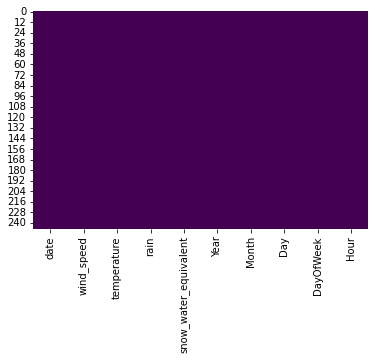

In [58]:
sns.heatmap(weather_features.isnull(), cbar=False, cmap='viridis')

Just to be sure, we fill the NANs with 0. Visually we didn't detect any, and the 6H aggregation shouldn't have any.

In [60]:
weather_features.fillna(0, inplace=True)
weather_features_6.fillna(0, inplace=True)

Categorizing and preparing for ohe.

In [61]:
weather_features["wind_category"] = weather_features["wind_speed"]
j = 0
for i in weather_features["wind_category"]:
    if i < 0.3:
        weather_features.loc[j, "wind_category"]= 0
    if  0.3 <= i < 1.6:
        weather_features.loc[j, "wind_category"]= 1
    if  1.6 <= i < 3.4:
        weather_features.loc[j, "wind_category"]= 2
    if  3.4 <= i < 5.5:
        weather_features.loc[j, "wind_category"]= 3
    if  5.5 <= i < 8:
        weather_features.loc[j, "wind_category"]= 4
    if  8 <= i < 10.8:
        weather_features.loc[j, "wind_category"]= 5
    if  10.8 <= i < 13.9:
        weather_features.loc[j, "wind_category"]= 6
    if  13.9 <= i < 17.2:
        weather_features.loc[j, "wind_category"]= 7
    if  17.2 <= i < 20.7:
        weather_features.loc[j, "wind_category"]= 8
    if  20.7 <= i < 24.4:
        weather_features.loc[j, "wind_category"]= 9
    if  24.4 <= i < 28.4:
        weather_features.loc[j, "wind_category"]= 10
    if  28.4 <= i < 32.6:
        weather_features.loc[j, "wind_category"]= 11
    if  i > 32.7:
        weather_features.loc[j, "wind_category"]= 12
    j +=1
    
weather_features["rain_category"] = weather_features["rain"]
j = 0
for i in weather_features["rain"]:
    if i < 0.5:
        weather_features.loc[j, "rain_category"]=0.5
    if 0.5 <= i < 2.5:
        weather_features.loc[j, "rain_category"]=2.5
    if 2.5 <= i < 5:
        weather_features.loc[j, "rain_category"]=5
    if 5 <= i < 10:
        weather_features.loc[j, "rain_category"]=10
    if 10 <= i < 50:
        weather_features.loc[j, "rain_category"]=50
    if i > 50:
        weather_features.loc[j, "rain_category"]=51
    j += 1
    
weather_features["temp_category"] = weather_features["temperature"]
j = 0
for i in weather_features["temperature"]:
    if i < 263.15:
        weather_features.loc[j, "temp_category"] = -10
    if 263.15 <= i < 273.15:
        weather_features.loc[j, "temp_category"] = 0   
    if 273.15 <= i < 283.15:
        weather_features.loc[j, "temp_category"] = 10   
    if 283.15 <= i < 291.15:
        weather_features.loc[j, "temp_category"] = 18
    if 291.15 <= i < 297.15:
        weather_features.loc[j, "temp_category"] = 24
    if 297.15 <= i < 303.15:
        weather_features.loc[j, "temp_category"] = 30
    if 303.15 <= i < 308.15:
        weather_features.loc[j, "temp_category"] = 35
    if i > 308.15:
        weather_features.loc[j, "temp_category"] = 35
    j+=1

weather_features["precipitation_form"] = weather_features["snow_water_equivalent"]
j = 0 
for i in weather_features["snow_water_equivalent"]:
    if i == 0:
        weather_features.loc[j, "precipitation_form"] = 0
    if i < 0:
        weather_features.loc[j, "precipitation_form"] = "error"
    if i > 0:
        weather_features.loc[j, "precipitation_form"] = 2
    j += 1
j=0
for i in weather_features["rain"]:
    if i >= 0.5:
        weather_features.loc[j, "precipitation_form"] = 1
    j += 1

In [62]:
weather_features = weather_features[["date", "Year", "Month", "Day", "DayOfWeek", "Hour", "wind_speed", "temperature", "rain",
                                       "snow_water_equivalent","wind_category", "rain_category", "temp_category", "precipitation_form"]]
weather_features.head(1)

,date,Year,Month,Day,DayOfWeek,Hour,wind_speed,temperature,rain,snow_water_equivalent,wind_category,rain_category,temp_category,precipitation_form
0,2022-06-28 10:00:00+00:00,2022,6,28,1,10,2.57,294.55,0.0,0.0,2.0,0.5,24.0,0.0
1,2022-06-28 11:00:00+00:00,2022,6,28,1,11,2.57,294.85,0.0,0.0,2.0,0.5,24.0,0.0
2,2022-06-28 12:00:00+00:00,2022,6,28,1,12,2.57,295.15,0.0,0.0,2.0,0.5,24.0,0.0
3,2022-06-28 13:00:00+00:00,2022,6,28,1,13,2.57,295.25,0.0,0.0,2.0,0.5,24.0,0.0
4,2022-06-28 14:00:00+00:00,2022,6,28,1,14,3.09,294.95,0.0,0.0,2.0,0.5,24.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,2022-07-08 12:00:00+00:00,2022,7,8,4,12,4.12,292.65,0.0,0.0,3.0,0.5,24.0,0.0
243,2022-07-08 13:00:00+00:00,2022,7,8,4,13,4.12,292.85,0.0,0.0,3.0,0.5,24.0,0.0
244,2022-07-08 14:00:00+00:00,2022,7,8,4,14,4.12,292.85,0.0,0.0,3.0,0.5,24.0,0.0
245,2022-07-08 15:00:00+00:00,2022,7,8,4,15,4.12,292.75,0.0,0.0,3.0,0.5,24.0,0.0


The same for 6H:

In [63]:
weather_features_6["wind_category"] = weather_features_6["wind_speed"]
j = 0
for i in weather_features_6["wind_category"]:
    if i < 0.3:
        weather_features_6.loc[j, "wind_category"]= 0
    if  0.3 <= i < 1.6:
        weather_features_6.loc[j, "wind_category"]= 1
    if  1.6 <= i < 3.4:
        weather_features_6.loc[j, "wind_category"]= 2
    if  3.4 <= i < 5.5:
        weather_features_6.loc[j, "wind_category"]= 3
    if  5.5 <= i < 8:
        weather_features_6.loc[j, "wind_category"]= 4
    if  8 <= i < 10.8:
        weather_features_6.loc[j, "wind_category"]= 5
    if  10.8 <= i < 13.9:
        weather_features_6.loc[j, "wind_category"]= 6
    if  13.9 <= i < 17.2:
        weather_features_6.loc[j, "wind_category"]= 7
    if  17.2 <= i < 20.7:
        weather_features_6.loc[j, "wind_category"]= 8
    if  20.7 <= i < 24.4:
        weather_features_6.loc[j, "wind_category"]= 9
    if  24.4 <= i < 28.4:
        weather_features_6.loc[j, "wind_category"]= 10
    if  28.4 <= i < 32.6:
        weather_features_6.loc[j, "wind_category"]= 11
    if  i > 32.7:
        weather_features_6.loc[j, "wind_category"]= 12
    j +=1
    
weather_features_6["rain_category"] = weather_features_6["rain"]
j = 0
for i in weather_features_6["rain"]:
    if i < 0.5:
        weather_features_6.loc[j, "rain_category"]=0.5
    if 0.5 <= i < 2.5:
        weather_features_6.loc[j, "rain_category"]=2.5
    if 2.5 <= i < 5:
        weather_features_6.loc[j, "rain_category"]=5
    if 5 <= i < 10:
        weather_features_6.loc[j, "rain_category"]=10
    if 10 <= i < 50:
        weather_features_6.loc[j, "rain_category"]=50
    if i > 50:
        weather_features_6.loc[j, "rain_category"]=51
    j += 1
    
weather_features_6["temp_category"] = weather_features_6["temperature"]
j = 0
for i in weather_features_6["temperature"]:
    if i < 263.15:
        weather_features_6.loc[j, "temp_category"] = -10
    if 263.15 <= i < 273.15:
        weather_features_6.loc[j, "temp_category"] = 0   
    if 273.15 <= i < 283.15:
        weather_features_6.loc[j, "temp_category"] = 10   
    if 283.15 <= i < 291.15:
        weather_features_6.loc[j, "temp_category"] = 18
    if 291.15 <= i < 297.15:
        weather_features_6.loc[j, "temp_category"] = 24
    if 297.15 <= i < 303.15:
        weather_features_6.loc[j, "temp_category"] = 30
    if 303.15 <= i < 308.15:
        weather_features_6.loc[j, "temp_category"] = 35
    if i > 308.15:
        weather_features_6.loc[j, "temp_category"] = 35
    j+=1


In [112]:
list1 =[]
count = 0
j = 0
for i in weather_features["precipitation_form"]:
    list1.append(i)
    count +=1
    if count == 6:
        c0 = list1.count(0)
        c1 = list1.count(1)
        c2 = list1.count(2)
        if c0 == c1 == c2:
            weather_features_6.loc[j, "precipitation_form"]=1
        elif c0==c1 & c0!=0:
            weather_features_6.loc[j, "precipitation_form"]=1
        elif c1 == c2 & c1!=0:
            weather_features_6.loc[j, "precipitation_form"]=1
        elif c0 == c2 & c0!=0:
            weather_features_6.loc[j, "precipitation_form"]=2
        else:
            weather_features_6.loc[j, "precipitation_form"]=most_frequent(list1)
        j+=1
        list1=[]
        count = 0

In [65]:
weather_features_6 = weather_features_6[["date", "Year", "Month", "Day", "DayOfWeek", "Hour", "wind_speed", "temperature", "rain",
                                       "wind_category", "rain_category", "temp_category", "precipitation_form"]]
weather_features_6.head(1)

,date,Year,Month,Day,DayOfWeek,Hour,wind_speed,temperature,rain,wind_category,rain_category,temp_category,precipitation_form
0,2022-06-28 06:00:00+00:00,2022,6,28,1,6,2.57,294.7,0.0,2.0,0.5,24.0,0


### One-Hot-Encoding 
To prepare the weather data for our ML models the columns get copied to a new dataframe and then transformed via ohe.

In [66]:
weather_features_ohe = weather_features.copy()
weather_features_ohe.drop(columns=["Year", "Month", "Day", "DayOfWeek", "Hour", "wind_speed", "temperature", "rain", "snow_water_equivalent"],
                         inplace=True)

weather_features_6_ohe = weather_features_6.copy()
weather_features_6_ohe.drop(columns=["Year", "Month", "Day", "DayOfWeek", "Hour", "wind_speed", "temperature", "rain"],
                           inplace=True)

In [67]:
weather_features_ohe = pd.get_dummies(weather_features_ohe, columns=["wind_category", "rain_category",
                                                                     "temp_category", "precipitation_form"])
weather_features_6_ohe = pd.get_dummies(weather_features_6_ohe, columns=["wind_category", "rain_category",
                                                                     "temp_category", "precipitation_form"])

In [69]:
weather_features_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247 entries, 0 to 246
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   date                    247 non-null    datetime64[ns, UTC]
 1   wind_category_1.0       247 non-null    uint8              
 2   wind_category_2.0       247 non-null    uint8              
 3   wind_category_3.0       247 non-null    uint8              
 4   wind_category_4.0       247 non-null    uint8              
 5   rain_category_0.5       247 non-null    uint8              
 6   rain_category_2.5       247 non-null    uint8              
 7   temp_category_18.0      247 non-null    uint8              
 8   temp_category_24.0      247 non-null    uint8              
 9   precipitation_form_0.0  247 non-null    uint8              
 10  precipitation_form_1.0  247 non-null    uint8              
dtypes: datetime64[ns, UTC](1), uint8(10)
memory u

Remove TZ and save again.

In [70]:
weather_features_6['date'] = weather_features_6['date'].dt.tz_localize(None)
weather_features_6.to_excel("Weather/forecast_weather_features_6.xlsx")

weather_features['date'] = weather_features['date'].dt.tz_localize(None)
weather_features.to_excel("Weather/forecast_weather_features.xlsx")

weather_features_6_ohe['date'] = weather_features_6_ohe['date'].dt.tz_localize(None)
weather_features_6_ohe.to_excel("Weather/forecast_weather_features_6_ohe.xlsx")

weather_features_ohe['date'] = weather_features_ohe['date'].dt.tz_localize(None)
weather_features_ohe.to_excel("Weather/forecast_weather_features_ohe.xlsx")

### Resampling of Visitor Data / Label Engineering

In [71]:
df_ss_2020 = pd.read_excel("Schleswig Holstein/Scharbeutz_Strand_allgemein_2020_x.xlsx")
df_ss_2021 = pd.read_excel("Schleswig Holstein/Scharbeutz_Strand_allgemein_2021_x.xlsx")
df_ss_2022 = pd.read_excel("Schleswig Holstein/Scharbeutz_Strand_allgemein_2022_x.xlsx")

Run a reformat so the data is all the same.

In [72]:
df_ss_2020["timestamp"] = pd.to_datetime(df_ss_2020["timestamp"])
df_ss_2020["date"] = pd.to_datetime(df_ss_2020["date"])
df_ss_2020["time"] = pd.to_datetime(df_ss_2020["time"],format= '%H:%M:%S' ).dt.time
df_ss_2020["full hour"] = pd.to_datetime(df_ss_2020["full hour"],format= '%H:%M:%S' ).dt.time

df_ss_2021["timestamp"] = pd.to_datetime(df_ss_2021["timestamp"])
df_ss_2021["date"] = pd.to_datetime(df_ss_2021["date"])
df_ss_2021["time"] = pd.to_datetime(df_ss_2021["time"],format= '%H:%M:%S' ).dt.time
df_ss_2021["full hour"] = pd.to_datetime(df_ss_2021["full hour"],format= '%H:%M:%S' ).dt.time

df_ss_2022["timestamp"] = pd.to_datetime(df_ss_2022["timestamp"])
df_ss_2022["date"] = pd.to_datetime(df_ss_2022["date"])
df_ss_2022["time"] = pd.to_datetime(df_ss_2022["time"],format= '%H:%M:%S' ).dt.time
df_ss_2022["full hour"] = pd.to_datetime(df_ss_2022["full hour"],format= '%H:%M:%S' ).dt.time

Taking a look at New Years Eve, people are leaving the beaches after midnight.

In [75]:
df_ss_2022.head(5)

,timestamp,date,time,full hour,area,value
0,2022-01-01 00:00:00,2022-01-01,00:00:00,00:00:00,"Scharbeutz, Strand allgemein",70
1,2022-01-01 00:15:00,2022-01-01,00:15:00,00:00:00,"Scharbeutz, Strand allgemein",-265
2,2022-01-01 00:30:00,2022-01-01,00:30:00,00:00:00,"Scharbeutz, Strand allgemein",-842
3,2022-01-01 00:45:00,2022-01-01,00:45:00,00:00:00,"Scharbeutz, Strand allgemein",-940
4,2022-01-01 01:00:00,2022-01-01,01:00:00,01:00:00,"Scharbeutz, Strand allgemein",-952


Check for double timestamps, see if the data is consistent so we can use it for our indices as well.  

Then we create a dataframe with time-steps of 15 minutes so that we won't miss any, as that is the chrono-resolution of our sensor data.  

We then take a look at the tail to see if the end fits or sits at 12AM as well. After cleaning that up, we merge on timestamp and concatenate the dataframes into one.

In [76]:
boolean1 = df_ss_2020['timestamp'].duplicated().any()
boolean2 = df_ss_2021['timestamp'].duplicated().any()
boolean3 = df_ss_2022['timestamp'].duplicated().any()

print(boolean1)
print(boolean2)
print(boolean3)

False
False
False


In [77]:
range_2020 = pd.date_range('2020-08-19', '2021-01-01', freq="15T")
range_2021 = pd.date_range('2021-01-01', '2022-01-01', freq="15T")
range_2022 = pd.date_range('2022-01-01', '2022-03-24', freq="15T")
df_20 = pd.DataFrame({ 'timestamp': range_2020})
df_21 = pd.DataFrame({ 'timestamp': range_2021})
df_22 = pd.DataFrame({ 'timestamp': range_2022})

In [78]:
#df_20.tail(3)
#df_21.tail(3)
df_22.tail(3)

,timestamp
7870,2022-03-23 23:30:00
7871,2022-03-23 23:45:00
7872,2022-03-24 00:00:00


In [79]:
df_20 = df_20[:-1]
df_21 = df_21[:-1]
df_22 = df_22[:-1]

In [80]:
df_20 = pd.merge(df_20, df_ss_2020, on="timestamp", how="left")
df_21 = pd.merge(df_21, df_ss_2021, on="timestamp", how="left")
df_22 = pd.merge(df_22, df_ss_2022, on="timestamp", how="left")

df = pd.concat([df_20, df_21, df_22])

Tackling any NaNs - always clean thoroughly.  
*"ML is 80% cleaning and optimizing data and 20% informed shenanigans."*

In [81]:
df.fillna(value=0, inplace=True)

In [82]:
df_hourly = df.copy()

# This would mask the negative values by 0 #
# During experimentation we noticed that the models predict better when keeping them

#df_hourly.value=df_hourly.value.mask(df_hourly.value.lt(0),0)
#df_hourly

Resampling from 15Mins to 1H (and 6H for some visualization)

In [84]:
df_hourly.set_index("timestamp", inplace=True)

df_hourly = df_hourly.resample("1H").mean()
df_6hours = df_hourly.resample("6H").mean()

df_hourly.head(3)

,value
timestamp,
2020-08-19 00:00:00,0.0
2020-08-19 01:00:00,0.0
2020-08-19 02:00:00,0.0


In [85]:
print("Max:",df_hourly.max(),"\n","\n","Min:",df_hourly.min())

Max: value    7186.75
dtype: float64 
 
 Min: value   -971.0
dtype: float64


### Visualizing the data
Looking for outliers and to get a general overview on distribution of our labels. Notice the post-midnight hike after New Year's Eve again by the locals leaving the beach for home.

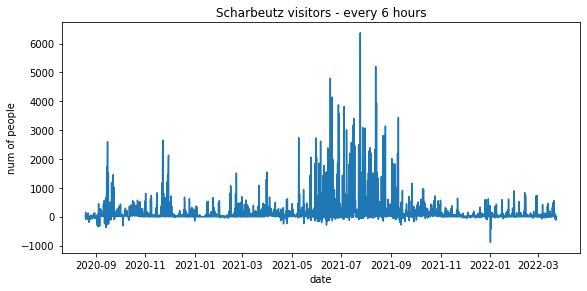

In [86]:
af = plt.figure()
axes = af.add_axes([0.1,0.1, 1.2,0.8])
axes.plot(df_6hours) # running this with 6H
axes.set_xlabel('date')
axes.set_ylabel('num of people')
axes.set_title('Scharbeutz visitors - every 6 hours')
af.savefig('Scharbeutz_visitors.jpg', dpi=300, bbox_inches="tight")

Saving again as a checkpoint.

In [89]:
df.to_excel("full_df_15min_Scharbeutz.xlsx")
df_hourly.to_excel("full_df_60min_Scharbeutz.xlsx")
df_6hours.to_excel("full_df_6h_Scharbeutz.xlsx")

### Merge the dataframes and prepare X and Y
We are preparing the input variables to build one dataframe. First we adjust the weather dataframe, then build dataframes for x and y, to afterwards merge them both on datetime - our index which makes sure we match the data properly and avoid any offset without noticing.

In [90]:
df_scharbeutz = pd.read_excel("full_df_60min_Scharbeutz.xlsx")
df_weather = pd.read_excel("Weather/weather_features_ohe.xlsx")

In [91]:
df_weather.rename(columns={"date": "datetime"}, inplace=True)
df_weather["date"] = df_weather["datetime"].dt.date
#df_time["date"]= df_time["Datum"].dt.date
x_df = df_weather.copy()
x_df['hour']=x_df['datetime'].dt.hour

In [92]:
x_df = x_df[["datetime", "date", "hour", 'wind_category_0.0', 'wind_category_1.0',
       'wind_category_2.0', 'wind_category_3.0', 'wind_category_4.0',
       'wind_category_5.0', 'wind_category_6.0', 'wind_category_7.0',
       'rain_category_0.5', 'rain_category_2.5', 'rain_category_5.0',
       'temp_category_-10.0', 'temp_category_0.0', 'temp_category_10.0',
       'temp_category_18.0', 'temp_category_24.0', 'temp_category_30.0',
       'precipitation_form_0.0', 'precipitation_form_1.0', 'precipitation_form_2.0'
            ]]

In [93]:
x_df.drop(columns=['date'], inplace=True)
x_df.head(3)

,datetime,hour,wind_category_0.0,wind_category_1.0,wind_category_2.0,wind_category_3.0,wind_category_4.0,wind_category_5.0,wind_category_6.0,wind_category_7.0,...,rain_category_5.0,temp_category_-10.0,temp_category_0.0,temp_category_10.0,temp_category_18.0,temp_category_24.0,temp_category_30.0,precipitation_form_0.0,precipitation_form_1.0,precipitation_form_2.0
0,2020-01-01 00:00:00,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
1,2020-01-01 01:00:00,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,2020-01-01 02:00:00,2,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [95]:
y_df = df_scharbeutz.copy()
y_df.reset_index(inplace=True)
y_df.rename(columns={"timestamp": "datetime"}, inplace=True)
y_df.head(3)

,index,datetime,value
0,0,2020-08-19 00:00:00,0.0
1,1,2020-08-19 01:00:00,0.0
2,2,2020-08-19 02:00:00,0.0


Time to merge!

In [96]:
df = pd.merge(y_df, x_df, how="inner", on="datetime")
df.drop(columns=["index"], inplace=True) 

In [97]:
df.to_excel("df.xlsx", index=False)

# Baseline - a simple persistence model  
In order to compare the ML models, let's use a primitive persistence model. It will only use the target data and provide us with a simple baseline for the timeseries.

https://machinelearningmastery.com/simple-time-series-forecasting-models/

<AxesSubplot:xlabel='datetime'>

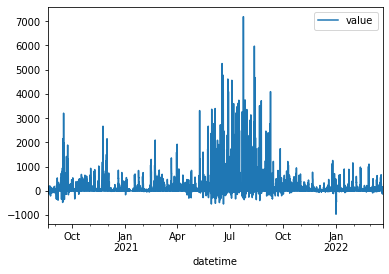

In [5]:
df = pd.read_excel("df.xlsx") # load the dataframe
df_y = df[["datetime", "value"]].copy() # we just copy datetime and value
df_y.set_index("datetime", inplace=True) # set the index
X = df_y.values # use df_y for X as well
df_y.plot() # plot the value distribution

In [15]:
df_y.shape

(13944, 1)

It's looking for the most fitting lag for the persistence values. We iterate in the range from 1 to 10.

In [18]:
persistence_values = range(1, 10) # range of lags to test
train, test = X[0:-3943], X[-9999:] # primitive split and take ~10k for train, ~3.9k for test

for p in persistence_values:
    history = [x for x in train] # walk-forward validation
    predictions = list()
    for i in range(len(test)):
        yhat = history[-p] # make prediction
        predictions.append(yhat)
        history.append(test[i])# observation
    rmse = mean_squared_error(test, predictions, squared=False)
    mae = mean_absolute_error(test, predictions)
    print('p=%d MAE:%.3f' % (p, mae))
    print('p=%d RMSE:%.3f' % (p, rmse))

p=1 MAE:72.161
p=1 RMSE:189.474
p=2 MAE:137.890
p=2 RMSE:348.157
p=3 MAE:196.956
p=3 RMSE:480.523
p=4 MAE:249.893
p=4 RMSE:588.896
p=5 MAE:295.632
p=5 RMSE:676.304
p=6 MAE:333.681
p=6 RMSE:743.740
p=7 MAE:364.028
p=7 RMSE:791.814
p=8 MAE:386.567
p=8 RMSE:823.238
p=9 MAE:402.315
p=9 RMSE:843.169


The primitive model with p=1 yields an MAE of 72, which is quite high. When looking at the outliers more, we'll get 189. That seems quite a lot, especially when considering that during off-season days the visitors are often just slightly above a hundred.

# KNeighborsRegressor - ML Model 1

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html
> Regression based on k-nearest neighbors.  
>
>The target is predicted by local interpolation of the targets associated of the nearest neighbors in the training set.

Transform the timeseries data for our supervised learning dataset!

https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

Then we split the dataset into train/test sets.

In [113]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols = list()
    
    # loop in the input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        
    # loop in the forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        
    # concatenate the aggregates
    agg = concat(cols, axis=1)
    
    # drop rows with evil NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

# split dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/  

For timeseries we should not use k-fold cross validation as they ignore temporal components which are part of the problem. Instead **walk-forward-validation** is preferable.  

In walk-forward-validation a model gets updated each time-step when new data is received.

This function is redefined for each Model!

In [126]:
def walk_forward_validation(data, n_test, ML_model):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = ML_model(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    # estimate prediction error
    error_mae = mean_absolute_error(test[:, -1], predictions)
    error_rmse = mean_squared_error(test[:, -1], predictions, squared=False)
    r2 = r2_score(test[:, -1],predictions)
    #return error_mae, error_rmse, test[:, -1], predictions
    return error_mae, error_rmse, test[:, 1], predictions, r2

**Load of running this:** Light.  
Assumption: Running 12 parallel jobs on 12 (physical) cores on an underclocked 5900X. 

Please adjust number of jobs accordingly at your discretion.

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html

Defining the KNeighboursRegressor for our timeseries!

In [178]:
def kNN_regressor(train, testX):
    # transform list into array
    train = asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = KNeighborsRegressor(n_neighbors=5, weights='uniform', algorithm='auto', n_jobs=24)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict([testX])
    return yhat[0]

Load the dataset (consecutively in the next models too, always doing this to start with a clean slate).

In [179]:
df = pd.read_excel("df.xlsx")
df.tail(1)

,datetime,value,hour,wind_category_0.0,wind_category_1.0,wind_category_2.0,wind_category_3.0,wind_category_4.0,wind_category_5.0,wind_category_6.0,...,rain_category_5.0,temp_category_-10.0,temp_category_0.0,temp_category_10.0,temp_category_18.0,temp_category_24.0,temp_category_30.0,precipitation_form_0.0,precipitation_form_1.0,precipitation_form_2.0
13943,2022-03-22 23:00:00,-124.25,23,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


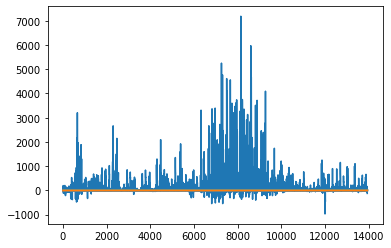

In [180]:
series = pd.read_excel("df.xlsx", header=0, index_col=0)
values = series.values
# plot dataset
plt.plot(values)
plt.show()

In [181]:
df_y = df[["datetime", "value"]].copy()

In [182]:
df_y.set_index("datetime", inplace=True)
values = df_y.values
values = values[1:-3]

In [183]:
values

array([[   0.  ],
       [   0.  ],
       [   0.  ],
       ...,
       [ -99.25],
       [-123.75],
       [-120.5 ]])

Now we transform the time series data for the supervised learning.

In [184]:
data = series_to_supervised(values, n_in=10)

Running KNeighboursRegressor through walk-forward-validation with 3409 runs.  

> Approx runtime on 24 cores at 3.6GHz: 1 minute.

In [185]:
start = time.time()
mae, rmse, y, yhat, r2 = walk_forward_validation(data, 3409, kNN_regressor)
ende = time.time()
print("Mean Absolute Error: %.3f" % mae)
print("Root Mean Squared Error: %.3f" % rmse)
print("F2-Score: %.3f" % r2)
print('{:5.3f}s'.format(ende-start), end='  ')

>expected=389.5, predicted=347.9
>expected=382.5, predicted=348.7
>expected=380.5, predicted=363.4
>expected=380.0, predicted=282.8
>expected=-1.5, predicted=69.4
>expected=-2.0, predicted=0.3
>expected=-2.0, predicted=0.1
>expected=-2.0, predicted=0.5
>expected=-2.0, predicted=0.7
>expected=-1.8, predicted=0.7
>expected=-2.8, predicted=3.5
>expected=8.8, predicted=12.5
>expected=20.0, predicted=21.9
>expected=32.8, predicted=44.4
>expected=64.2, predicted=66.7
>expected=109.2, predicted=98.0
>expected=157.5, predicted=176.3
>expected=149.8, predicted=201.9
>expected=157.0, predicted=121.5
>expected=143.5, predicted=153.3
>expected=87.8, predicted=148.2
>expected=42.5, predicted=84.3
>expected=12.5, predicted=47.2
>expected=15.2, predicted=16.3
>expected=18.5, predicted=24.4
>expected=20.2, predicted=16.8
>expected=18.5, predicted=15.1
>expected=18.8, predicted=8.7
>expected=1.0, predicted=1.4
>expected=2.0, predicted=-3.5
>expected=2.0, predicted=-2.6
>expected=2.0, predicted=-0.9
>ex

### Evaluation  

For timeseries in regression models, we don't use Accuracy or F1-Scores or the latter's two components. Multiple sources say F2-Score as well as MAE with RMSE are preferable when analyzing time-series in regressor models. The baseline was no regressor model so F2 wouldn't be applicable. https://medium.com/@20__80__/mean-absolute-error-mae-machine-learning-ml-b9b4afc63077

With the first dataframes including features from ohe such as days of the week, days of the month, local holidays, bridge-days, weekends and a resampling towards 6H the MAE was much higher (above 300), while the RMSE exploded into thousands, indicating way too many outliers. This is crucial for the key summer days with high visitor counts. We do not want to be off there. Model experimentation did not help the issue much, so the data was looked at again. Feature engineering the dataframe again and again and improving upon it gave much better results. True to the quote *"Shenanigans in, shenanigans out"*.   

It seems that it is more important to the visitors on how the weather is and it might imply that many visitors are often more spontaneous, not planning "to go on Wednesday" but rather "The sun shines, we got time, let's go!". Weather is very important, its weight correlates with the number of visitors to the beach.  

When the model ran on the re-engineered features again, we got much better results. An F2-Score of 0.875, the MAE at 23.245, and the RMSE down to 55, showing a good reduction on the outliers in our prediction. The model's runtime scales impressively well on 24 jobs, with just 1 minute of computation time.
Compared to the baseline these results are already much better.

But our F2-Score is not in the 90s yet, so we will compare two more ML Models.

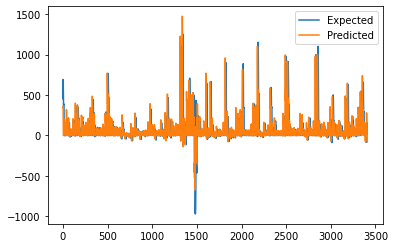

In [154]:
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.savefig("images\kNN_regressor_results")
plt.show()

In [155]:
df1 = pd.DataFrame(y)
list_kNN = [*range(0,3409)]
#list_kNN = [*range(0,569)]
df1["index"]=list_kNN
df1.set_index("index", inplace=True)
df1.rename(columns={0: "Expected"}, inplace=True)
df2 = pd.DataFrame(yhat)
results = pd.concat([df1,df2],axis=1)
results.rename(columns={0:"Predicted"}, inplace=True)
results["datetime"] = pd.date_range('2021-11-01', '2022-03-23', freq="1H") 
#results["datetime"] = pd.date_range('2021-11-01', '2022-03-23', freq="6H")
results.set_index("datetime", inplace=True)

In [156]:
results.to_excel("Results\kNN-Regressor.xlsx")

Run KNeighborRegressor again with less runs to see how the walk-forward-validation affects score.

In [157]:
start = time.time()
mae, rmse, y, yhat, r2 = walk_forward_validation(data, 569, kNN_regressor)
ende = time.time()
print("Mean Absolute Error: %.3f" % mae)
print("Root Mean Squared Error: %.3f" % rmse)
print("F2-Score: %.3f" % r2)
print('{:5.3f}s'.format(ende-start), end='  ')

>expected=-2.0, predicted=-1.9
>expected=0.0, predicted=-0.9
>expected=3.8, predicted=2.8
>expected=64.5, predicted=13.6
>expected=106.8, predicted=101.6
>expected=215.5, predicted=193.8
>expected=439.8, predicted=340.6
>expected=809.5, predicted=657.1
>expected=1004.2, predicted=941.0
>expected=1101.8, predicted=1005.0
>expected=982.8, predicted=875.8
>expected=715.5, predicted=743.1
>expected=367.2, predicted=515.1
>expected=241.0, predicted=223.7
>expected=165.8, predicted=85.0
>expected=147.8, predicted=62.5
>expected=142.2, predicted=39.6
>expected=141.8, predicted=153.5
>expected=146.5, predicted=149.2
>expected=147.0, predicted=90.4
>expected=-2.0, predicted=11.3
>expected=-2.0, predicted=-2.4
>expected=-2.0, predicted=-1.3
>expected=-2.0, predicted=-3.8
>expected=-2.0, predicted=-1.2
>expected=-2.0, predicted=-0.3
>expected=-3.8, predicted=8.3
>expected=15.5, predicted=10.4
>expected=22.5, predicted=20.0
>expected=48.8, predicted=52.9
>expected=91.2, predicted=73.9
>expected=12

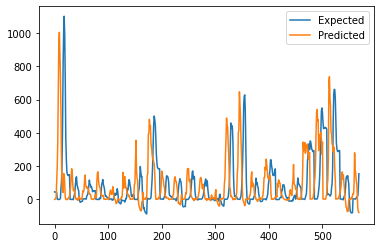

In [158]:
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.savefig("images\kNN_regressor_results_569")
plt.show()

### Evaluation  
Judging from the higher F2-Score of 0.932 and seemingly better results with a MAE at 23.22, this is too good. *"It's a trap!"* What has happened? The runs in the walk-forward-validation are not enough to train into the highly fluctuating summer times! Time series predictions get less accurate over time, which is what the walk-forward-validation is set up against.  

Here the model simply had a too easy time yet.  

I wanted to mention this as it is an interesting observation and the higher scores may lead to a false sense of security. We also notice a certain lag in the expected result. Hence I consider the 3409 runs to be more true.  

https://www.tutorialspoint.com/time_series/time_series_walk_forward_validation.htm  

# Support Vector Machine - Regression - ML Model 2

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
> Regression based on Epsilon-Support Vector.
>
>The fit time complexity is more than quadratic with the number of samples which makes it hard to scale to datasets with more than a couple of 10000 samples.

In [159]:
def SVR_forecast(train, testX):
    # transform list into array
    train = asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = make_pipeline(StandardScaler(), SVR(kernel='linear',C=1.0, epsilon=0.2))
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict([testX])
    return yhat[0]

Load the dataset

In [160]:
df = pd.read_excel("df.xlsx")
df.head(2)

,datetime,value,hour,wind_category_0.0,wind_category_1.0,wind_category_2.0,wind_category_3.0,wind_category_4.0,wind_category_5.0,wind_category_6.0,...,rain_category_5.0,temp_category_-10.0,temp_category_0.0,temp_category_10.0,temp_category_18.0,temp_category_24.0,temp_category_30.0,precipitation_form_0.0,precipitation_form_1.0,precipitation_form_2.0
0,2020-08-19 00:00:00,0.0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1,2020-08-19 01:00:00,0.0,1,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [161]:
df_y = df[["datetime", "value"]].copy()

df_y.set_index("datetime", inplace=True)
values = df_y.values
values = values[1:-3]

values

array([[   0.  ],
       [   0.  ],
       [   0.  ],
       ...,
       [ -99.25],
       [-123.75],
       [-120.5 ]])

In [162]:
data = series_to_supervised(values, n_in=10)

In [163]:
start = time.time()
#mae, rmse, y, yhat, r2 = walk_forward_validation(data, 569, SVR_forecast)
mae, rmse, y, yhat, r2 = walk_forward_validation(data, 3409, SVR_forecast)
ende = time.time()
print('MAE: %.3f' % mae)
print('RMSE: %.3f' % rmse)
print("F2-Score: %.3f" % r2)
print('{:5.3f}s'.format(ende-start), end='  ')

>expected=389.5, predicted=353.9
>expected=382.5, predicted=369.4
>expected=380.5, predicted=364.2
>expected=380.0, predicted=360.0
>expected=-1.5, predicted=358.7
>expected=-2.0, predicted=-41.0
>expected=-2.0, predicted=-62.1
>expected=-2.0, predicted=-10.3
>expected=-2.0, predicted=0.1
>expected=-1.8, predicted=1.8
>expected=-2.8, predicted=3.4
>expected=8.8, predicted=5.1
>expected=20.0, predicted=15.6
>expected=32.8, predicted=22.0
>expected=64.2, predicted=39.7
>expected=109.2, predicted=71.6
>expected=157.5, predicted=118.4
>expected=149.8, predicted=166.7
>expected=157.0, predicted=154.2
>expected=143.5, predicted=153.5
>expected=87.8, predicted=139.4
>expected=42.5, predicted=79.0
>expected=12.5, predicted=30.0
>expected=15.2, predicted=4.0
>expected=18.5, predicted=13.3
>expected=20.2, predicted=22.4
>expected=18.5, predicted=24.6
>expected=18.8, predicted=23.2
>expected=1.0, predicted=22.9
>expected=2.0, predicted=3.9
>expected=2.0, predicted=3.9
>expected=2.0, predicted=6.4

### Evaluation  
The F2-Score of 0.887 has improved compared to the KNeighborsRegressor. Of course the MAE at 22.510 is also better, and the RMSE which weights points more further away from the mean shows significantly less volatility at 52.251. However, an SVR may not be the preferable solution.  

Reason: The computational time of 224 minutes is very high. This is because the Support Vector Regressor can't scale computation in parallel jobs, while its fit time complexity is more than quadratic.  

This behavior was observed with multiple different runs, number of runs, multiple kernel selections. In fact this run was on the computationally easiest linear kernel, separating spaces linearly. It is thus still not the best choice from a ratio of results-quality for runtime.  

Information on the different kernels of SVM and SVR here:  
https://scikit-learn.org/stable/modules/svm.html

In [164]:
mae_ = mean_absolute_error(y, yhat)
mae_

117.79112399615398

In [165]:
df1 = pd.DataFrame(y)
#list_svr = [*range(0,569)]
list_svr = [*range(0,3409)]
df1["index"]=list_svr
df1.set_index("index", inplace=True)
df1.rename(columns={0: "Expected"}, inplace=True)
df2 = pd.DataFrame(yhat)
results = pd.concat([df1,df2],axis=1)
results.rename(columns={0:"Predicted"}, inplace=True)
#results["datetime"] = pd.date_range('2021-11-01', '2022-03-23', freq="6H")
results["datetime"] = pd.date_range('2021-11-01', '2022-03-23', freq="1H")
results.set_index("datetime", inplace=True)

In [166]:
results.to_excel("Results\SVM_timeseries.xlsx")

# Random Forest Regressor - ML Model 3

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
> Regression based on Random Forest Decision Trees.
>
> A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

In [167]:
def random_forest_forecast(train, testX):
    # transform list into array
    train = asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = RandomForestRegressor(n_estimators=500, n_jobs=24)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict([testX])
    return yhat[0]

In [168]:
df = pd.read_excel("df.xlsx")

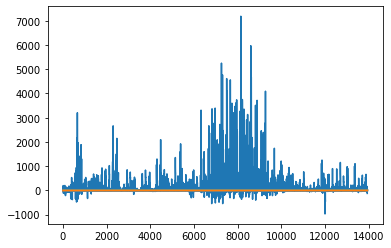

In [169]:
series = pd.read_excel("df.xlsx", header=0, index_col=0)
values = series.values

plt.plot(values)
plt.show()

In [170]:
df_y = df[["datetime", "value"]].copy()

In [171]:
df_y.set_index("datetime", inplace=True)
values = df_y.values
values = values[1:-3]
values

array([[   0.  ],
       [   0.  ],
       [   0.  ],
       ...,
       [ -99.25],
       [-123.75],
       [-120.5 ]])

In [172]:
data = series_to_supervised(values, n_in=10)

Run the Random Forest.

In [173]:
# evaluate (Home system Ryzen 5900X, 24 jobs: Computing time approx 141min with 3409 on 24 jobs)
start = time.time()
#mae, rmse, y, yhat, r2 = walk_forward_validation(data, 569, random_forest_forecast)
mae, rmse, y, yhat, r2 = walk_forward_validation(data, 3409, random_forest_forecast)
ende = time.time()
print('MAE: %.3f' % mae)
print('RMSE: %.3f' % rmse)
print("F2-Score: %.3f" % r2)
print('{:5.3f}s'.format(ende-start), end='  ')

>expected=389.5, predicted=369.8
>expected=382.5, predicted=375.5
>expected=380.5, predicted=338.1
>expected=380.0, predicted=276.1
>expected=-1.5, predicted=191.4
>expected=-2.0, predicted=-2.4
>expected=-2.0, predicted=-1.7
>expected=-2.0, predicted=-2.0
>expected=-2.0, predicted=-2.1
>expected=-1.8, predicted=-0.5
>expected=-2.8, predicted=0.5
>expected=8.8, predicted=0.7
>expected=20.0, predicted=30.8
>expected=32.8, predicted=27.3
>expected=64.2, predicted=64.1
>expected=109.2, predicted=109.9
>expected=157.5, predicted=181.2
>expected=149.8, predicted=195.3
>expected=157.0, predicted=158.7
>expected=143.5, predicted=164.3
>expected=87.8, predicted=128.0
>expected=42.5, predicted=65.5
>expected=12.5, predicted=13.4
>expected=15.2, predicted=-11.3
>expected=18.5, predicted=14.0
>expected=20.2, predicted=16.6
>expected=18.5, predicted=17.5
>expected=18.8, predicted=13.9
>expected=1.0, predicted=8.4
>expected=2.0, predicted=0.5
>expected=2.0, predicted=1.3
>expected=2.0, predicted=1.

Plot the results and take a look at the fit.

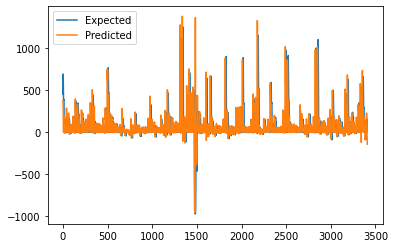

In [174]:
# plot expected vs predicted
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.savefig("images\RFR_results")
plt.show()

### Evaluation  
The F2-Score of 0.906 has improved considerably compared to the other models, but also to the initial runs of RFR itself on not properly prepared dataframes! The lesson of "*Shenanigans in, shenanigans out!*" rings true yet again. It shows how important feature engineering and properly adjusted labels are as well in supervised machine learning experiments. The MAE is also very low at 19.444: We must keep in mind that - if we were to build a predictor with a dashboard and everything for the customer - we are especially interested about predictions on heavy visitor load, for example on hot summer days.  

RMSE helps with that as well, giving more weight to the points further away from the mean:  Visitor numbers can reach multiple thousands, during exploration we have seen a maximum of 7186 concurrent visitors per hour during summer, and a approximately 150 during bad days. In that context, even a prediction that is off by 718 still warns us about 6468 visitors coming in.  

Increasing number of estimators to 1000 led to diminishing returns and no better precision, and lowering it to 100 reduced precision, hence 500 seems to be the sweet spot.

When looking at the runtime, the RFR ran just 141 minutes on 24 parallel jobs with 3409 runs on 500 estimators. Thus it scales very well compared to the SVR, while achieving the F2 above 90%.  

**The RFR is hence the best model in our selection of experiments regarding performance vs runtime**

### Final overview


| Classifier | MAE | RSME | F2-Score | Runtime |
| --- | --- | --- | --- | --- |
| Baseline | 72 | 189 | nA | 1s |
| KNR | 23.245 | 55.071 | 0.875 | 65s |
| SVR | 22.510 | 52.251 | 0.887 | 13439s |
| RFR | 19.444 | 47.733 | 0.906 | 8461s |

In [176]:
df1 = pd.DataFrame(y)
list_rfr = [*range(0,3409)] # match range of list to number of runs in walk_forward_validation
#list_rfr = [*range(0,569)]
df1["index"]=list_rfr
df1.set_index("index", inplace=True)
df1.rename(columns={0: "Expected"}, inplace=True)
df2 = pd.DataFrame(yhat)
results = pd.concat([df1,df2],axis=1)
results.rename(columns={0:"Predicted"}, inplace=True)
results["datetime"] = pd.date_range('2021-11-01', '2022-03-23', freq="1H")
#results["datetime"] = pd.date_range('2021-11-01', '2022-03-23', freq="6H")
results.set_index("datetime", inplace=True)

In [177]:
results.to_excel("Results\Random_forest_timeseries.xlsx")